# Get Data

Note: data is the three scale channel features

In [11]:
import gc
import h5py
import numpy as np

load_path='F:/wangqi/nistcomparison/AAPlantD1_2GHz_TX1_hpol_run4_pp.mat'
load_mat=h5py.File(load_path,'r')
IQdata=load_mat['IQdata'][3600:39600,0:256].view('complex')
locations=120
records=300

# load_path='F:/wangqi/nistdataset/GBurgD2_2GHz_TX1_longPol_run2_pp.mat'
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][500:9800,0:256].view('complex')
# locations=186
# records=50

# Hyper-parameters

In [12]:
# training parameters
seed = 0                        # random seed
batch_size = 32                # batch size
num_epoch = 50                   # the number of training epoch
patience = 5                  # If no improvement in 'patience' epochs, early stop
learning_rate = 0.0005          # learning rate
weight_decay=1e-5
model_path = './model.ckpt'     # the path where the checkpoint will be saved

# model parameters
k=1  #H为k个h
nf=1 #参考CSI的数量
index=[0,1]
# index=[0,2,1,3]
# index=[0,1,2,3]
# index=[0,8,1,9,2,10,3,11,4,12,5,13,6,14,7,15]
# index=[0,3,1,4,2,5]
# index=[0,1,2,3,4,5]
d=2  #eve在alice后面d-1个位置处尾随
input_channels=4
len_sequence = 256                  # the input dim of the model, you should not change the value
output_dim=2
mu=0.4
std=0.1

# creat a image

In [13]:
import numpy as np
from numpy import fft

def minmaxscaler(data):
    min = np.amin(data)
    max = np.amax(data)    
    return (data - min)/(max-min)

def convert_pic(h):
    width, height=h.shape
    img=np.zeros([input_channels,width,height]).astype(np.float32)
    img[0,:,:]=minmaxscaler(np.abs(h))
    img[1,:,:]=np.angle(h)
    img[2,:,:]=minmaxscaler(np.abs(fft.fft2(h)))
    img[3,:,:]=np.angle(fft.fft2(h))
    return img

# creatH

In [14]:
def creatHimag_Alice(idx, k, nf):
    H=np.zeros((k+nf,len_sequence)).astype(complex)
    H=IQdata[idx-nf:idx+k]
    # print(np.shape(H))
    return  np.transpose(H[index])
    # return  np.transpose(H)
def creatHimag_Eve(idx, k, nf, d):
    H=np.zeros((k+nf,len_sequence)).astype(complex)
    H[nf:k+nf,:]=IQdata[idx-d*records:idx+k-d*records]
    H[0:nf,:]=IQdata[idx-nf:idx]
    return  np.transpose(H[index])
    # return  np.transpose(H)

# Preprocess data 

In [15]:
recs=records*d
num_dataall=locations*records-recs-10
dataall_HimagA=np.zeros((num_dataall,len_sequence, k+nf)).astype(complex)
dataall_HimagE=np.zeros((num_dataall,len_sequence, k+nf)).astype(complex)
for i in range(recs,locations*records-10):
    dataall_HimagA[i-recs,:,:]=creatHimag_Alice(i,k=k,nf=nf)
    dataall_HimagE[i-recs,:,:]=creatHimag_Eve(i,k=k,nf=nf,d=d)

dataall_TW=np.concatenate((dataall_HimagA,dataall_HimagE),axis=0)
location=[i for i in range(2)]
test_data=dataall_TW
test_lab=[val for val in location for i in range(int(num_dataall))]
train_data=dataall_TW[0:int(num_dataall*2):2]
train_label=[val for val in location for i in range(int(num_dataall/2))]
valid_data=dataall_TW[1:int(num_dataall*2):2]
valid_label=[val for val in location for i in range(int(num_dataall/2))]

del dataall_HimagA, dataall_HimagE, dataall_TW
gc.collect()

7388

# Define Dataset

In [16]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class hDataset(Dataset):
    def __init__(self, k, X, y=None):
        super(hDataset).__init__()
        # self.data = torch.DoubleTensor(abs(X))
        self.data = X
        self.k = k
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        h = self.data[idx]
        h = convert_pic(h)
        if self.label is not None:
            return h, self.label[idx]
        else:
            return h

    def __len__(self):
        return len(self.data)


# Prepare dataset and model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from model_my import myNet
import os
# get dataset
train_set = hDataset(k,train_data, train_label)
valid_set = hDataset(k,valid_data, valid_label)

# remove raw feature to save memory
# del train_data, valid_data, valid_label
# gc.collect()

# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')
# create model, define a loss function, and optimizer
net = myNet(num_classes=output_dim, aux_logits=False, init_weights=False)
# in_channel = net.fc.in_features
# net.fc = nn.Linear(in_channel, output_dim)
net.to(device)

criterion = nn.CrossEntropyLoss() 
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=learning_rate, weight_decay= weight_decay)

DEVICE: cuda:1


# Training

In [18]:
import tqdm
import sys
stale=0
best_acc = 0.0
_exp_name = "HM_hrun4_adappla_3132p5152p_sample"
train_losses=[]
train_accss=[]
valid_losses=[]
valid_accss=[]

for epoch in range(num_epoch):
    net.train()
    train_loss=[]
    train_accs=[]
# ---training---
    # train_bar = tqdm(train_loader, file=sys.stdout)
    # for batch in enumerate(train_bar):
    for batch in train_loader:    
        H, labels =batch
        H = H.to(device)
        labels = labels.to(device)
   
        optimizer.zero_grad()

        logits = net(H.to(device))
        loss =criterion(logits, labels.to(device))   
        loss.backward()
        optimizer.step()
        
        acc=(logits.argmax(dim=-1) == labels.to(device)).float().mean()
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_losses.append(train_loss)
    train_accss.append(np.array(train_acc.cpu()))
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{num_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

# ---validation---
    net.eval()
    valid_loss=[]
    valid_accs=[]

    # for batch in tqdm(valid_loader):
    for batch in valid_loader:
        # A batch consists of image data and corresponding labels.
        H, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = net(H.to(device))
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_losses.append(valid_loss)
    valid_accss.append(np.array(valid_acc.cpu()))
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{num_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")        

    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{num_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{num_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    # if epoch % 50 == 0:
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(net.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break   

[ Train | 001/050 ] loss = 0.15522, acc = 0.93648
[ Valid | 001/050 ] loss = 0.04467, acc = 0.98423
[ Valid | 001/050 ] loss = 0.04467, acc = 0.98423 -> best
Best model found at epoch 0, saving model
[ Train | 002/050 ] loss = 0.05458, acc = 0.98675
[ Valid | 002/050 ] loss = 0.04602, acc = 0.98408
[ Valid | 002/050 ] loss = 0.04602, acc = 0.98408
[ Train | 003/050 ] loss = 0.04519, acc = 0.99025
[ Valid | 003/050 ] loss = 0.02175, acc = 0.99335
[ Valid | 003/050 ] loss = 0.02175, acc = 0.99335 -> best
Best model found at epoch 2, saving model
[ Train | 004/050 ] loss = 0.03974, acc = 0.99166
[ Valid | 004/050 ] loss = 0.03312, acc = 0.98827
[ Valid | 004/050 ] loss = 0.03312, acc = 0.98827
[ Train | 005/050 ] loss = 0.03487, acc = 0.99282
[ Valid | 005/050 ] loss = 0.01594, acc = 0.99401
[ Valid | 005/050 ] loss = 0.01594, acc = 0.99401 -> best
Best model found at epoch 4, saving model
[ Train | 006/050 ] loss = 0.03006, acc = 0.99336
[ Valid | 006/050 ] loss = 0.01483, acc = 0.99480


# Loss and Acc show

<function matplotlib.pyplot.show(close=None, block=None)>

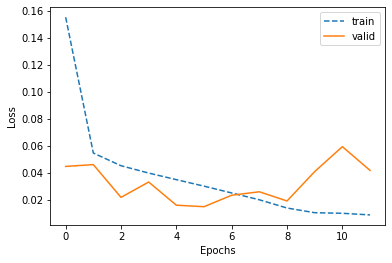

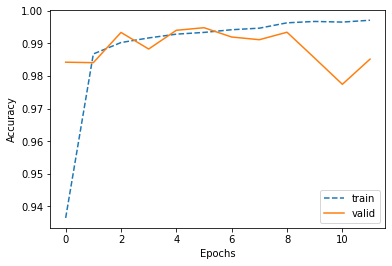

In [19]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

plt.figure(1)
plt.plot(train_losses, linestyle="--", label="train")
plt.plot(valid_losses, linestyle="-", label="valid")
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

plt.figure(2)
plt.plot(train_accss, linestyle="--", label="train")
plt.plot(valid_accss, linestyle="-", label="valid")
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show

# Testing

In [20]:
import numpy as np
test_set = hDataset(k, test_data, test_lab)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model_best =myNet(num_classes=output_dim, aux_logits=False, init_weights=False).to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"),strict=False)
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

accuracy=1 - np.count_nonzero(np.array(prediction)-np.array(test_lab))/len(prediction)

print(accuracy)
print(1-accuracy)

0.9948855608929076
0.005114439107092417
